In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


/tmp/ipykernel_26846/1506272096.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


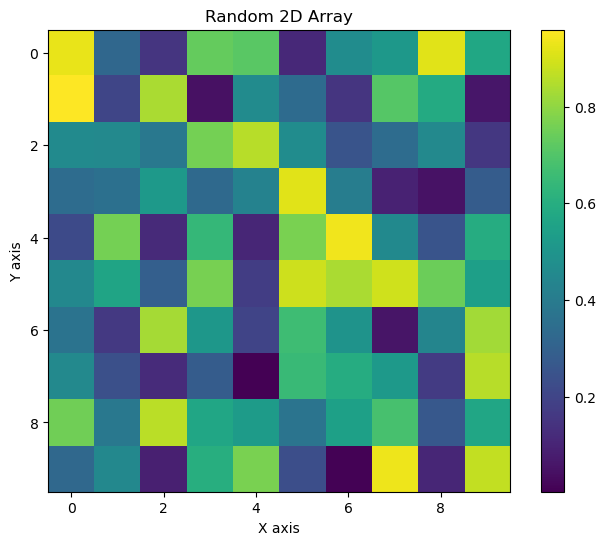

In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

import modules.spikingjelly;
from modules.spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from modules.spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from modules.spikingjelly.datasets.n_mnist import NMNIST
# from modules.spikingjelly.datasets.es_imagenet import ESImageNet
from modules.spikingjelly.datasets import split_to_train_test_set
from modules.spikingjelly.datasets.n_caltech101 import NCaltech101
from modules.spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import modules.torchneuromorphic as torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz
from turtle import shape


In [3]:
import apex

In [4]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [5]:


def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 25_000,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                    
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_coin = 0, # swap할 수 있는 coin 개수

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 
                    dvs_relative_timestep = True, 
                    
                    I_wanna_sweep_at_this_epoch = -1,
                    dvs_duration_domain = [(25_000,1,False)],

                    extra_train_dataset = 0,

                    num_workers = 2,
                    chaching_on = False,
                    pin_memory = True, # True # False
                    
                    UDA_on = False, # True # False
                    UDA_data = (25_000,1,False), # (duration, clipping, denoise_on)
                    src_trg_ratio = 1,
                    adapter_loss_weight = 1.0, # 1.0  # adapter loss의 힘.
                    alpha_uda = 1.0,

                    temporal_filter = 1, 
                    initial_pooling = 1,
                    ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    if UDA_on == True:
        assert single_step == True and BPTT_on == False and I_wanna_sweep_at_this_epoch == -1 and (e_transport_swap_coin == 0 or (e_transport_swap == 0 and e_transport_swap_tr == 0)) and isinstance(cfg, tuple) == True and extra_train_dataset == 0
    if temporal_filter > 1:
        assert convTrue_fcFalse == False
    if initial_pooling > 1:
        pass
    if extra_train_dataset > 0:
        assert which_data != 'NMNIST_TONIC'
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                            include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                            exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path or '.git/' in path or 'tonic' in path or 'torchneuromorphic' in path or 'spikingjelly' in path 
                            )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_data_split_indices = []
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM, train_data_count = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME*temporal_filter, # temporal_filter가 곱해짐.
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on,
            my_seed,
            extra_train_dataset,
            num_workers,
            chaching_on,
            pin_memory,
            train_data_split_indices,) 
    test_loader_domain_set = []
    test_loader_domain_set.append(test_loader)  
    synapse_fc_out_features = CLASS_NUM
    if UDA_on == True:
        train_loader = None

        # pin_memory_breaker = torch.arange(0, 1) #이거 주석 하면 느리고, 이거 주석 안 하면 빠름. NN결과는 같음. 뭐가 문제야..? 아마 torch를 건드리면서 pin_memory에 문제를 일으키는 거 같기는 하다. 이걸 주석 해제하거나, pin_memory를 False로 하는 거나 속도와 cpu 점유가 비슷하다.
        indices= list(range(train_data_count))
        random.shuffle(indices)
        train_data_split_indices_source = indices[:math.ceil(train_data_count * (src_trg_ratio / (src_trg_ratio + 1)))]
        train_data_split_indices_target = indices[math.ceil(train_data_count * (src_trg_ratio / (src_trg_ratio + 1))):]
        train_loader, _, synapse_conv_in_channels, CLASS_NUM, train_data_count_src = data_loader(
                which_data,
                data_path, 
                rate_coding, 
                BATCH, 
                IMAGE_SIZE,
                ddp_on,
                TIME*temporal_filter, # temporal_filter가 곱해짐.
                dvs_clipping,
                dvs_duration,
                exclude_class,
                merge_polarities,
                denoise_on,
                my_seed,
                extra_train_dataset,
                num_workers,
                chaching_on,
                pin_memory,
                train_data_split_indices_source,
                )
        
        train_loader_target, _, synapse_conv_in_channels, CLASS_NUM, train_data_count_trg = data_loader(
                which_data,
                data_path, 
                rate_coding, 
                BATCH, 
                IMAGE_SIZE,
                ddp_on,
                TIME*temporal_filter,
                UDA_data[1],  # dvs_clipping,
                UDA_data[0],   # dvs_duration,
                exclude_class,
                merge_polarities,
                UDA_data[2], # denoise_on,
                my_seed,
                extra_train_dataset,
                num_workers,
                chaching_on,
                pin_memory,
                train_data_split_indices_target,
                )
        print('\n','src img count',train_data_count_src,'trg img count',train_data_count_trg,'\n')
    ###########################################################################################################################################
    
    ## 다른 dvs duration domain을 validation set으로 불러오기 ##############################################################
    dvs_duration_domain_temp = []
    train_data_split_indices = []
    if len(dvs_duration_domain) > 0:
        for domain in dvs_duration_domain:
            target_domain_timestep = (dvs_duration*TIME)//domain[0] if dvs_relative_timestep == True else TIME
            dvs_duration_domain_temp.append(domain + (target_domain_timestep,))
            train_loader_domain, test_loader_domain, synapse_conv_in_channels_domain, CLASS_NUM_domain, train_data_count = data_loader(
                    which_data,
                    data_path, 
                    rate_coding, 
                    BATCH, 
                    IMAGE_SIZE,
                    ddp_on,
                    target_domain_timestep*temporal_filter,
                    domain[1], # dvs_clipping
                    domain[0], # dvs_duration
                    exclude_class,
                    merge_polarities,
                    domain[2], # denoise_on 
                    my_seed,
                    extra_train_dataset,
                    num_workers,
                    chaching_on,
                    pin_memory,
                    train_data_split_indices,)
            test_loader_domain_set.append(test_loader_domain)
        dvs_duration_domain = dvs_duration_domain_temp
    ######################################################################################################################
    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE//initial_pooling
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (UDA_on == True):
        print("In UDA mode, No parameter number calculation yet.")
        pass
    else: 
        if (convTrue_fcFalse == True):
            past_kernel = synapse_conv_in_channels
            for kernel in cfg:
                if (classifier_making == False):
                    if (type(kernel) == list):
                        for residual_kernel in kernel:
                            if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                                residual_kernel -= 10000
                                params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                                params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                                past_kernel = residual_kernel  
                            elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                                residual_kernel -= 20000
                                # 'past_kernel' should be same with 'kernel'
                                params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                                past_kernel = residual_kernel  
                            else:
                                params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                                past_kernel = residual_kernel
                    elif (kernel == 'P' or kernel == 'M'):
                        img_size = img_size // 2
                    elif (kernel == 'D'):
                        img_size = 1
                    elif (kernel == 'L'):
                        classifier_making = True
                        past_kernel = past_kernel * (img_size**2)
                    else:
                        if (kernel >= 10000 and kernel < 20000): # separable
                            kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * kernel
                            past_kernel = kernel  
                        elif (kernel >= 20000 and kernel < 30000): # depthwise
                            kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = kernel  
                        else:
                            params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                            past_kernel = kernel    
                else: # classifier making
                    params_num += (past_kernel + bias_param) * kernel
                    past_kernel = kernel
            
            
            if classifier_making == False:
                past_kernel = past_kernel*img_size*img_size

            params_num += (past_kernel + bias_param) * synapse_fc_out_features
        else:
            in_channel_compute_temp = synapse_conv_in_channels * temporal_filter
            past_in_channel = in_channel_compute_temp*img_size*img_size
            for in_channel in cfg:
                if (type(in_channel) == list):
                    for residual_in_channel in in_channel:
                        params_num += (past_in_channel + bias_param) * residual_in_channel
                        past_in_channel = residual_in_channel
                elif (in_channel == 'P' or in_channel == 'M'):
                    img_size = img_size // 2
                    past_in_channel = in_channel_compute_temp*img_size*img_size
                else:
                    params_num += (past_in_channel + bias_param) * in_channel
                    past_in_channel = in_channel
            params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\ndevice ==> {device}\n")
    if device == "cpu":
        print("="*50,"\n[WARNING]\n[WARNING]\n[WARNING]\n: cpu mode\n\n","="*50)

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels*temporal_filter, IMAGE_SIZE//initial_pooling, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate,
                        UDA_on,
                        alpha_uda).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels*temporal_filter, IMAGE_SIZE//initial_pooling, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate,
                        UDA_on,
                        alpha_uda).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE//initial_pooling,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate,
                        UDA_on,
                        alpha_uda).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE//initial_pooling,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate,
                        UDA_on,
                        alpha_uda).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME

    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss = 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    DFA_BP_toggle_trial = 0
    iter_of_val = False
    tr_acc_target = 0
    tr_correct_target = 0
    tr_total_target = 0
    tr_acc_best_target = 0
    tr_epoch_loss_temp_target = 0
    tr_epoch_loss_target = 0
    tr_epoch_loss_temp_domain = 0
    tr_epoch_loss_domain = 0
    tr_acc_domain = 0
    tr_correct_domain = 0
    tr_total_domain = 0
    val_acc_now_set_past = [0 for _ in range(len(dvs_duration_domain)+1)]
    val_acc_now_set = [0 for _ in range(len(dvs_duration_domain)+1)]
    val_acc_now_set_best = [0 for _ in range(len(dvs_duration_domain)+1)]
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (I_wanna_sweep_at_this_epoch == epoch):
            net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
            no_val_best_growth_count = 0
            DFA_current = not DFA_current
            DFA_toggle = True
            DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
        else:
            if (e_transport_swap > 0 or e_transport_swap_tr > 0):
                assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
                if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap :
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_val_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
                if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_tr_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (UDA_on == True):
            iterator_target = enumerate(train_loader_target, 0)

        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        i = 0
        target_done = False
        for i, data in iterator:
            UDA_FSM = 0
            while (UDA_FSM < 2): # 0: source, 1: target, 2: done
                if UDA_on == True:
                    if UDA_FSM == 0:
                        net.UDA_adapter_on = True # net.UDA_adapter_on 와 net.UDA_classifier_on은 그냥 flag임. 이번에 loss값을 backward할 건지 말 건지 ㅇㅇ
                        net.UDA_classifier_on = True
                        if target_done == True:
                            UDA_FSM = 2 # 2--> target 안함
                        elif (i)%(len(train_loader)//len(train_loader_target)) == 0: # 일정 주기로 src/trg 도메인 어댑트
                        # elif torch.rand(1).item() < (1/src_trg_ratio):
                            net.UDA_adapter_on = True
                            UDA_FSM = 1 # 1--> target 함 !!! target 할 때만 source도 domain adapt할거면 net.UDA_adapter_on을 False로 잘 조정
                        elif i == len(train_loader) - 1 and target_done == False:
                            net.UDA_adapter_on = True
                            UDA_FSM = 1
                        else: 
                            UDA_FSM = 2
                    elif UDA_FSM == 1:
                        net.UDA_adapter_on = True
                        net.UDA_classifier_on = False
                        tgt_idx, data = next(iterator_target)
                        target_done = True if tgt_idx == len(train_loader_target) - 1 else False
                        if i == len(train_loader) - 1 and target_done == False:
                            UDA_FSM = 1
                        else: 
                            UDA_FSM = 2
                    else:
                        assert False
                else:
                    UDA_FSM = 2

                iter_one_train_time_start = time.time()

                net.train() # train 모드로 바꿔줘야함

                ### data loading & semi-pre-processing ################################################################################
                if len(data) == 2:
                    inputs, labels = data
                    # 처리 로직 작성
                elif len(data) == 3:
                    inputs, labels, x_len = data
                    # print('x_len',x_len)
                    # mask = padded_sequence_mask(x_len)
                    # max_time_step = x_len.max()
                    # min_time_step = x_len.min()
                else:
                    assert False, 'data length is not 2 or 3'
                #######################################################################################################################
                    
                ## batch 크기 ######################################
                real_batch = labels.size(0)
                ###########################################################

                # 차원 전처리
                ###########################################################################################################################        
                if (which_data == 'n_tidigits'):
                    inputs = inputs.permute(0, 1, 3, 2, 4)
                    labels = labels[:, 0, :]
                    labels = torch.argmax(labels, dim=1)
                elif (which_data == 'heidelberg'):
                    inputs = inputs.view(5, 1000, 1, 700, 1)
                    print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
                # print('inputs',inputs.size(),'\nlabels',labels.size())
                # print(labels)

                if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                    inputs = inputs.permute(1, 0, 2, 3, 4)
                elif rate_coding == True :
                    inputs = spikegen.rate(inputs, num_steps=TIME)
                else :
                    inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                # inputs: [Time, Batch, Channel, Height, Width]  
                    
                ## initial pooling #######################################################################
                if (initial_pooling > 1):
                    pool = nn.MaxPool2d(kernel_size=2)
                    num_pooling_layers = int(math.log2(initial_pooling))
                    # Time, Batch, Channel 차원은 그대로 두고, Height, Width 차원에 대해서만 pooling 적용
                    shape_temp = inputs.shape
                    inputs = inputs.reshape(shape_temp[0]*shape_temp[1], shape_temp[2], shape_temp[3], shape_temp[4])
                    for _ in range(num_pooling_layers):
                        inputs = pool(inputs)
                    inputs = inputs.reshape(shape_temp[0], shape_temp[1], shape_temp[2], shape_temp[3]//initial_pooling, shape_temp[4]//initial_pooling)
                ## initial pooling #######################################################################
                ## temporal filtering ####################################################################
                shape_temp = inputs.shape
                if (temporal_filter > 1):
                    slice_bucket = []
                    for t_temp in range(TIME):
                        start = t_temp * temporal_filter
                        end = start + temporal_filter
                        slice_concat = torch.movedim(inputs[start:end], 0, 1).reshape(shape_temp[1],shape_temp[2],shape_temp[3],-1)
                        slice_bucket.append(slice_concat)
                    inputs = torch.stack(slice_bucket, dim=0)
                ## temporal filtering ####################################################################
                ####################################################################################################################### 
                    
                
                # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
                # ##############################################################################################
                # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
                # #####################################################################################################

                ## to (device) #######################################
                inputs = inputs.to(device)
                labels = labels.to(device)
                ###########################################################


                ## gradient 초기화 #######################################
                optimizer.zero_grad()
                ###########################################################
                
                ## DVS gesture에서 other label자리 매꾸기 ###############
                if (which_data == 'DVS_GESTURE'):
                    labels[labels>2] -= 1
                #######################################################         
                                
                if merge_polarities == True:
                    inputs = inputs[:,:,0,:,:]

                if single_step == False:
                    # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                    # inputs: [Time, Batch, Channel, Height, Width]   
                    inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                    # inputs: [Batch, Time, Channel, Height, Width] 
                    #################################################################################################
                else:
                    labels = labels.repeat(TIME, 1)
                    ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                    if OTTT_input_trace_on == True:
                        spike = inputs
                        trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                        inputs = []
                        for t in range(TIME):
                            trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                            inputs += [[spike[t], trace[t]]]
                    ##################################################################################################


                if single_step == False:
                    ### input --> net --> output #####################################################
                    outputs = net(inputs)
                    ##################################################################################
                    ## loss, backward ##########################################
                    iter_loss = criterion(outputs, labels)
                    iter_loss.backward()
                    ############################################################
                    ## weight 업데이트!! ##################################
                    optimizer.step()
                    ################################################################
                else:
                    if UDA_on == False:
                        outputs_all = []
                        iter_loss = 0.0
                        for t in range(TIME):
                            ### input[t] --> net --> output_one_time #########################################
                            outputs_one_time = net(inputs[t])
                            ##################################################################################
                            one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                            one_time_loss.backward() # one_time backward
                            iter_loss += one_time_loss.data
                            outputs_all.append(outputs_one_time.detach())
                        optimizer.step() # full step time update
                        outputs_all = torch.stack(outputs_all, dim=1)
                        outputs = outputs_all.mean(1) # ottt꺼 쓸때
                        labels = labels[0]
                        iter_loss /= TIME
                    else:
                        ## 근데 생각해보니까 걍 target에서 classifier만 backward 안 해주면 되는 거 아니냐

                        iter_loss_domain = 0.0
                        outputs_all = []
                        outputs_all_domain = []
                        iter_loss = 0.0

                        if net.UDA_classifier_on == True:
                            domain_labels = torch.full((TIME, real_batch), 1).to(device)
                        else:
                            domain_labels = torch.full((TIME, real_batch), 0).to(device)
                            
                        for t in range(TIME):
                            ### input[t] --> net --> output_one_time #########################################
                            outputs_one_time, UDA_adpater_out = net(inputs[t])
                            one_time_loss_classifier = criterion(outputs_one_time, labels[t].contiguous())
                            one_time_loss_domain = criterion(UDA_adpater_out, domain_labels[t].contiguous())
                            one_time_loss_backward = torch.tensor(0.0).to(device)
                            if net.UDA_adapter_on == True:
                                one_time_loss_backward += one_time_loss_domain * adapter_loss_weight
                            else:
                                one_time_loss_backward += one_time_loss_domain * 0.0
                            if net.UDA_classifier_on == True:
                                one_time_loss_backward += one_time_loss_classifier
                            else:
                                one_time_loss_backward += one_time_loss_classifier * 0.0
                            one_time_loss_backward.backward() # one_time backward
                            iter_loss += one_time_loss_classifier.data
                            iter_loss_domain += one_time_loss_domain.data
                            outputs_all.append(outputs_one_time.detach())
                            outputs_all_domain.append(UDA_adpater_out.detach())
                            ##################################################################################
                        if one_time_loss_backward != 0.0:
                            optimizer.step() # full step time update
                        outputs_all = torch.stack(outputs_all, dim=1)
                        outputs = outputs_all.mean(1) # ottt꺼 쓸때
                        labels = labels[0]
                        outputs_all_domain = torch.stack(outputs_all_domain, dim=1)
                        outputs_domain = outputs_all_domain.mean(1) # ottt꺼 쓸때
                        domain_labels = domain_labels[0]
                        iter_loss /= TIME
                        iter_loss_domain /= TIME

                if UDA_on == False:
                    tr_epoch_loss_temp += iter_loss.data/len(train_loader)
                else: 
                    if (net.UDA_classifier_on == True):
                        tr_epoch_loss_temp += iter_loss.data/(len(train_loader)*src_trg_ratio/(src_trg_ratio+1))
                    else:
                        tr_epoch_loss_temp_target += iter_loss.data/(len(train_loader)*1/(src_trg_ratio+1))
                    tr_epoch_loss_temp_domain += iter_loss.data/len(train_loader)

                ## net 그림 출력해보기 #################################################################
                # print('시각화')
                # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
                # return 0
                ##################################################################################

                #### batch 어긋남 방지 ###############################################
                assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                #######################################################################
                

                if UDA_on == False:
                    ####### training accruacy save for print ###############################
                    _, predicted = torch.max(outputs.data, 1)
                    total = real_batch
                    correct = (predicted == labels).sum().item()
                    iter_acc = correct / total
                    tr_total += total
                    tr_correct += correct
                    if i % verbose_interval == verbose_interval-1:
                        if ddp_on == False or torch.distributed.get_rank() == 0:
                            print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
                    iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
                    iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
                    ################################################################
                else:
                    ####### training accruacy save for print ###############################
                    _, predicted = torch.max(outputs.data, 1)
                    _, predicted_domain = torch.max(outputs_domain.data, 1)
                    total = real_batch
                    correct = (predicted == labels).sum().item()
                    correct_domain = (predicted_domain == domain_labels).sum().item()
                    iter_acc = correct / total
                    iter_acc_domain = correct_domain / total
                    if (net.UDA_classifier_on == True):
                        tr_total += total
                        tr_correct += correct
                    else:
                        tr_total_target += total
                        tr_correct_target += correct
                    tr_correct_domain += correct_domain
                    tr_total_domain += total

                    if i % verbose_interval == verbose_interval-1:
                        if ddp_on == False or torch.distributed.get_rank() == 0:
                            print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
                    iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
                    iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
                    ################################################################




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")
            
            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1 :
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                if UDA_on == True:
                    tr_acc_target = tr_correct_target/tr_total_target
                    tr_correct_target = 0
                    tr_total_target = 0
                    tr_acc_domain = tr_correct_domain/tr_total_domain
                    tr_correct_domain = 0
                    tr_total_domain = 0

                domain_index = 0
                val_loss_set = []
                val_acc_now_set = []
                while True:
                    val_loss = 0
                    correct_val = 0
                    total_val = 0
                    test_loader = test_loader_domain_set[domain_index]
                    domain_index = domain_index + 1

                    with torch.no_grad():
                        net.eval() # eval 모드로 바꿔줘야함 
                        for data_val in test_loader:
                            ## data_val loading & semi-pre-processing ##########################################################
                            if len(data_val) == 2:
                                inputs_val, labels_val = data_val
                                # 처리 로직 작성
                            elif len(data_val) == 3:
                                inputs_val, labels_val, x_len = data_val
                                # print('x_len',x_len)
                                # mask = padded_sequence_mask(x_len)
                                # max_time_step = x_len.max()
                                # min_time_step = x_len.min()
                                # B, T, *spatial_dims = inputs_val.shape
                            else:
                                assert False, 'data_val length is not 2 or 3'

                            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                                inputs_val = inputs_val.permute(1, 0, 2, 3, 4)
                            elif rate_coding == True :
                                inputs_val = spikegen.rate(inputs_val, num_steps=TIME)
                            else :
                                inputs_val = inputs_val.repeat(TIME, 1, 1, 1, 1)
                            # inputs_val: [Time, Batch, Channel, Height, Width]  
                            ###################################################################################################
                            
                            ## initial pooling #######################################################################
                            if (initial_pooling > 1):
                                pool = nn.MaxPool2d(kernel_size=2)
                                num_pooling_layers = int(math.log2(initial_pooling))
                                # Time, Batch, Channel 차원은 그대로 두고, Height, Width 차원에 대해서만 pooling 적용
                                shape_temp = inputs_val.shape
                                inputs_val = inputs_val.reshape(shape_temp[0]*shape_temp[1], shape_temp[2], shape_temp[3], shape_temp[4])
                                for _ in range(num_pooling_layers):
                                    inputs_val = pool(inputs_val)
                                inputs_val = inputs_val.reshape(shape_temp[0], shape_temp[1], shape_temp[2], shape_temp[3]//initial_pooling, shape_temp[4]//initial_pooling)
                            ## initial pooling #######################################################################

                            ## temporal filtering ####################################################################
                            shape_temp = inputs_val.shape
                            if (temporal_filter > 1):
                                slice_bucket = []
                                for t_temp in range(TIME):
                                    start = t_temp * temporal_filter
                                    end = start + temporal_filter
                                    slice_concat = torch.movedim(inputs_val[start:end], 0, 1).reshape(shape_temp[1],shape_temp[2],shape_temp[3],-1)
                                    slice_bucket.append(slice_concat)
                                inputs_val = torch.stack(slice_bucket, dim=0)
                            ## temporal filtering ####################################################################
                            
                            inputs_val = inputs_val.to(device)
                            labels_val = labels_val.to(device)
                            real_batch = labels_val.size(0)
                            
                            ## DVS gesture에서 other label자리 매꾸기 ###############
                            if (which_data == 'DVS_GESTURE'):
                                labels_val[labels_val>2] -= 1
                            #######################################################
                            
                            if merge_polarities == True:
                                inputs_val = inputs_val[:,:,0,:,:]

                            ## network 연산 시작 ############################################################################################################
                            if single_step == False:
                                outputs = net(inputs_val.permute(1, 0, 2, 3, 4)) #inputs_val: [Batch, Time, Channel, Height, Width]  
                                val_loss_val += criterion(outputs, labels_val)/len(test_loader)
                            else:
                                outputs_all = []
                                for t in range(TIME):
                                    outputs = net(inputs_val[t])
                                    if UDA_on == True:
                                        outputs = outputs[0] # classifier의 output만 사용.
                                    val_loss_temp = criterion(outputs, labels_val)
                                    outputs_all.append(outputs.detach())
                                    val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                                outputs_all = torch.stack(outputs_all, dim=1)
                                outputs = outputs_all.mean(1)
                            val_loss_set.append(val_loss)
                            #################################################################################################################################

                            _, predicted = torch.max(outputs.data, 1)
                            total_val += real_batch
                            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                            correct_val += (predicted == labels_val).sum().item()

                        val_acc_now = correct_val / total_val
                        # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')
                        val_acc_now_set.append(val_acc_now)

                    if domain_index == len(dvs_duration_domain) + 1:
                        break

                val_loss = val_loss_set[0]
                val_acc_now = val_acc_now_set[0]

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0
                tr_epoch_loss_target = tr_epoch_loss_temp_target 
                tr_epoch_loss_temp_target = 0
                tr_epoch_loss_domain = tr_epoch_loss_temp_domain
                tr_epoch_loss_temp_domain = 0
                if (UDA_on == True):
                    print(f"Domain loss,acc: {tr_epoch_loss_domain:.6f}, {100 * tr_acc_domain:.2f}% Target domain: tr_loss-{tr_epoch_loss_target:.6f}, tr_acc-{100 * tr_acc_target:.2f}%")

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter_loss:{iter_loss:10.6f}, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  

                    if len(dvs_duration_domain) > 0:
                        dvs_duration_full = [(dvs_duration, dvs_clipping, denoise_on, TIME)] + dvs_duration_domain
                        val_acc_now_set_best = [max(past, now) for past, now in zip(val_acc_now_set_past, val_acc_now_set)]
                        print(" | ".join(f"{dvs_duration_full[d_count][0]:,}c{dvs_duration_full[d_count][1]}d{dvs_duration_full[d_count][2]}t{dvs_duration_full[d_count][3]}:{val_acc_now_set[d_count]*100:.2f}%:{val_acc_now_set_best[d_count]*100:.2f}%" for d_count in range(len(val_acc_now_set))))
                        val_acc_now_set_past = val_acc_now_set_best
                    iter_of_val = False
            
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss})   
                if len(val_acc_now_set) > 1:
                    wandb.log({"val_acc_now_set[1]": val_acc_now_set[1]}) 
                    wandb.log({"val_acc_now_set[1]_best": val_acc_now_set_best[1]}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)


            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
            # iterator.update(1)
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board (Gesture) ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "0",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','CIFAR10','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 0.720291189014991, # 1.3102821334243646,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 10000, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 3.555718888923306, # 2.570969004857107 # sigmoid류에서는 alpha값 4.0, rectangle류에서는 width값 0.5

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                # cfg = ['M',200],
                # cfg = [200,200],
                # cfg = ['M','M',200,200],
                cfg = ([200],[200],[200],[2]), # (feature extractor, classifier, domain adapter, # of domain)
                # cfg = (['M','M',200],[200],[200],[2]), # (feature extractor, classifier, domain adapter, # of domain)
                # cfg = ['M',200,200],
                # cfg = ['M','M',1024,512,256,128,64],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [],        
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.001, #0.1 bptt, #0.01 ottt, # default 0.001  # ottt 0.1 # nda 0.001 # 0.00936191669529645
                epoch_num = 300,
                verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'sigmoid' 'rectangle' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'no', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 5, #일반적으로 1 또는 2 # 100ms때는 5 # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101
                # gesture: 100_000c1-5, 25_000c5, 10_000c5, 1_000c5, 1_000_000c5

                dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐
                # nmnist 5_000us, gesture는 100_000us, 25_000us

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = False, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                
                e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_coin = 1, # swap할 수 있는 coin 개수

                drop_rate = 0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

                exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
                denoise_on = False, # True # False # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

                I_wanna_sweep_at_this_epoch = -1, # 지정 에포크에서 BP와 DFA를 바꿔줌. -1이면 실행 안함.
                # dvs_duration_domain=[(100_000,5,False),(125_000,5,False),(150_000,5,False),],
                # dvs_duration_domain=[(40_000,4,False),(50_000,4,False),(60_000,4,False),],
                # [duration, clipping, denoise_on]
                dvs_duration_domain=[(50_000,5,False)],
                dvs_relative_timestep = False, # True # False 
                
                extra_train_dataset = 0,

                num_workers = 2, # local wsl에서는 2가 맞고, 서버에서는 4가 좋더라.
                chaching_on = True, # True # False # only for certain datasets (gesture_tonic, nmnist_tonic)
                pin_memory = True, # True # False 

                UDA_on = True, # True # False
                UDA_data = (50_000,5,False), # (duration, clipping, denoise_on)
                src_trg_ratio = 2, # (1이상의 정수) src data와 trg data의 개수 비율 (대략적으로)
                adapter_loss_weight = 0.0, # 1.0  # adapter loss의 힘. # 이걸 0으로하면 src only learning.
                alpha_uda = 1.0, # GRL의 alpha값

                temporal_filter = 1, # 1이면 아무것도 안함. 한타임스텝에 쑤셔 넣을 window개수. 
                initial_pooling = 4, # 1이면 pooling 안함. 2의 승수만 입력하셈. log2를 취해서 pooling할 window size를 결정함.
                ) 

# num_workers = 4 * num_GPU (or 8, 16, 2 * num_GPU)
# entry * batch_size * num_worker = num_GPU * GPU_throughtput
# num_workers = batch_size / num_GPU
# num_workers = batch_size / num_CPU

# sigmoid와 BN이 있어야 잘된다.
# average pooling  
# 이 낫다. 

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드0
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


dataset_hash = ffa516e60c3efd5e0208f72b4c36cb84
cache path exists
dataset_hash = ffa516e60c3efd5e0208f72b4c36cb84
cache path exists
dataset_hash = 11943e830202e5a130c37c1da0a9af65
cache path exists

 src img count 653 trg img count 326 

dataset_hash = 11943e830202e5a130c37c1da0a9af65
cache path exists
In UDA mode, No parameter number calculation yet.

device ==> cuda

DataParallel(
  (module): MY_SNN_FC_sstep(
    (UDA_feature_layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
    )
    (UDA_classifier_layers): MY_Sequential(
      (0): SYNAPSE_FC_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): SYNAPSE_FC_trace_sstep()
    )
    (UDA_adapter_layers): MY_Sequential(
      (0): Gradient_Reversal_Layer()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 0, system's param_num : 492,612
Memory: 0.00MiB at 32-bit


epoch-0   lr=['0.0010000'], tr/val_loss:  3.448946/  2.267884, tr:  10.26%, val:  18.75%, val_best:  18.75%: 100%|██████████| 41/41 [00:12<00:00,  3.36it/s]

Domain loss,acc: 3.479058, 41.37% Target domain: tr_loss-3.539283, tr_acc-9.51%
100,000c5dFalset10:18.75%:18.75% | 50,000c5dFalset10:12.92%:12.92%



epoch-1   lr=['0.0010000'], tr/val_loss:  3.093921/  1.863492, tr:  32.47%, val:  45.42%, val_best:  45.42%: 100%|██████████| 41/41 [00:11<00:00,  3.55it/s]

Domain loss,acc: 3.223763, 54.95% Target domain: tr_loss-3.483447, tr_acc-19.63%
100,000c5dFalset10:45.42%:45.42% | 50,000c5dFalset10:34.17%:34.17%



epoch-2   lr=['0.0010000'], tr/val_loss:  2.413883/  1.593927, tr:  54.67%, val:  53.33%, val_best:  53.33%: 100%|██████████| 41/41 [00:11<00:00,  3.55it/s]

Domain loss,acc: 2.614746, 51.28% Target domain: tr_loss-3.016470, tr_acc-39.88%
100,000c5dFalset10:53.33%:53.33% | 50,000c5dFalset10:44.17%:44.17%



epoch-3   lr=['0.0010000'], tr/val_loss:  2.014901/  1.485065, tr:  63.40%, val:  57.50%, val_best:  57.50%: 100%|██████████| 41/41 [00:11<00:00,  3.51it/s]

Domain loss,acc: 2.249362, 47.40% Target domain: tr_loss-2.718284, tr_acc-43.87%
100,000c5dFalset10:57.50%:57.50% | 50,000c5dFalset10:45.42%:45.42%



epoch-4   lr=['0.0010000'], tr/val_loss:  1.796730/  1.440591, tr:  67.38%, val:  60.42%, val_best:  60.42%: 100%|██████████| 41/41 [00:11<00:00,  3.48it/s]

Domain loss,acc: 2.046850, 45.86% Target domain: tr_loss-2.547090, tr_acc-46.63%
100,000c5dFalset10:60.42%:60.42% | 50,000c5dFalset10:45.83%:45.83%



epoch-5   lr=['0.0010000'], tr/val_loss:  1.570065/  1.386757, tr:  74.73%, val:  60.83%, val_best:  60.83%: 100%|██████████| 41/41 [00:11<00:00,  3.52it/s]

Domain loss,acc: 1.893409, 44.02% Target domain: tr_loss-2.540096, tr_acc-45.09%
100,000c5dFalset10:60.83%:60.83% | 50,000c5dFalset10:46.67%:46.67%



epoch-6   lr=['0.0010000'], tr/val_loss:  1.452637/  1.430988, tr:  73.51%, val:  61.67%, val_best:  61.67%: 100%|██████████| 41/41 [00:11<00:00,  3.51it/s]

Domain loss,acc: 1.769112, 45.97% Target domain: tr_loss-2.402063, tr_acc-50.31%
100,000c5dFalset10:61.67%:61.67% | 50,000c5dFalset10:47.92%:47.92%



epoch-7   lr=['0.0010000'], tr/val_loss:  1.276463/  1.440117, tr:  80.55%, val:  59.17%, val_best:  61.67%: 100%|██████████| 41/41 [00:12<00:00,  3.29it/s]

Domain loss,acc: 1.656388, 46.37% Target domain: tr_loss-2.416236, tr_acc-50.31%
100,000c5dFalset10:59.17%:61.67% | 50,000c5dFalset10:45.42%:47.92%



epoch-8   lr=['0.0010000'], tr/val_loss:  1.117832/  1.415048, tr:  87.60%, val:  60.42%, val_best:  61.67%: 100%|██████████| 41/41 [00:12<00:00,  3.37it/s]

Domain loss,acc: 1.542541, 45.76% Target domain: tr_loss-2.391957, tr_acc-52.45%
100,000c5dFalset10:60.42%:61.67% | 50,000c5dFalset10:49.17%:49.17%



epoch-9   lr=['0.0010000'], tr/val_loss:  1.062075/  1.463516, tr:  85.30%, val:  60.00%, val_best:  61.67%: 100%|██████████| 41/41 [00:12<00:00,  3.37it/s]

Domain loss,acc: 1.536301, 46.37% Target domain: tr_loss-2.484754, tr_acc-50.00%
100,000c5dFalset10:60.00%:61.67% | 50,000c5dFalset10:50.42%:50.42%



epoch-10  lr=['0.0010000'], tr/val_loss:  0.938242/  1.454225, tr:  89.74%, val:  63.33%, val_best:  63.33%: 100%|██████████| 41/41 [00:11<00:00,  3.45it/s]

Domain loss,acc: 1.440017, 47.19% Target domain: tr_loss-2.443566, tr_acc-54.60%
100,000c5dFalset10:63.33%:63.33% | 50,000c5dFalset10:52.50%:52.50%



epoch-11  lr=['0.0010000'], tr/val_loss:  0.857182/  1.565178, tr:  88.82%, val:  57.50%, val_best:  63.33%: 100%|██████████| 41/41 [00:11<00:00,  3.45it/s]

Domain loss,acc: 1.438405, 44.13% Target domain: tr_loss-2.600850, tr_acc-52.15%
100,000c5dFalset10:57.50%:63.33% | 50,000c5dFalset10:48.75%:52.50%



epoch-12  lr=['0.0010000'], tr/val_loss:  0.713758/  1.523287, tr:  95.87%, val:  66.25%, val_best:  66.25%: 100%|██████████| 41/41 [00:11<00:00,  3.52it/s]

Domain loss,acc: 1.313173, 45.35% Target domain: tr_loss-2.512004, tr_acc-57.06%
100,000c5dFalset10:66.25%:66.25% | 50,000c5dFalset10:53.75%:53.75%



epoch-13  lr=['0.0010000'], tr/val_loss:  0.634149/  1.534073, tr:  96.94%, val:  65.42%, val_best:  66.25%: 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]

Domain loss,acc: 1.261816, 45.66% Target domain: tr_loss-2.517149, tr_acc-59.51%
100,000c5dFalset10:65.42%:66.25% | 50,000c5dFalset10:57.50%:57.50%



epoch-14  lr=['0.0010000'], tr/val_loss:  0.551327/  1.548229, tr:  97.40%, val:  72.50%, val_best:  72.50%: 100%|██████████| 41/41 [00:11<00:00,  3.62it/s]

Domain loss,acc: 1.227892, 43.72% Target domain: tr_loss-2.581023, tr_acc-58.28%
100,000c5dFalset10:72.50%:72.50% | 50,000c5dFalset10:56.25%:57.50%



epoch-15  lr=['0.0010000'], tr/val_loss:  0.488572/  1.596169, tr:  97.70%, val:  69.17%, val_best:  72.50%: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]

Domain loss,acc: 1.201341, 45.56% Target domain: tr_loss-2.626879, tr_acc-61.66%
100,000c5dFalset10:69.17%:72.50% | 50,000c5dFalset10:57.92%:57.92%



epoch-16  lr=['0.0010000'], tr/val_loss:  0.431573/  1.573449, tr:  99.54%, val:  68.75%, val_best:  72.50%: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

Domain loss,acc: 1.186070, 43.21% Target domain: tr_loss-2.695064, tr_acc-55.21%
100,000c5dFalset10:68.75%:72.50% | 50,000c5dFalset10:57.92%:57.92%



epoch-17  lr=['0.0010000'], tr/val_loss:  0.357601/  1.633082, tr:  99.69%, val:  71.67%, val_best:  72.50%: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

Domain loss,acc: 1.155432, 44.54% Target domain: tr_loss-2.751093, tr_acc-58.28%
100,000c5dFalset10:71.67%:72.50% | 50,000c5dFalset10:56.25%:57.92%



epoch-18  lr=['0.0010000'], tr/val_loss:  0.308310/  1.695118, tr:  99.54%, val:  70.42%, val_best:  72.50%: 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]

Domain loss,acc: 1.128024, 44.54% Target domain: tr_loss-2.767453, tr_acc-63.19%
100,000c5dFalset10:70.42%:72.50% | 50,000c5dFalset10:57.92%:57.92%



epoch-19  lr=['0.0010000'], tr/val_loss:  0.257554/  1.747961, tr:  99.85%, val:  69.58%, val_best:  72.50%: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]

Domain loss,acc: 1.122044, 42.70% Target domain: tr_loss-2.851025, tr_acc-61.96%
100,000c5dFalset10:69.58%:72.50% | 50,000c5dFalset10:59.17%:59.17%



epoch-20  lr=['0.0010000'], tr/val_loss:  0.227942/  1.802419, tr:  99.85%, val:  72.50%, val_best:  72.50%: 100%|██████████| 41/41 [00:11<00:00,  3.62it/s]

Domain loss,acc: 1.126105, 43.92% Target domain: tr_loss-2.922431, tr_acc-60.43%
100,000c5dFalset10:72.50%:72.50% | 50,000c5dFalset10:59.17%:59.17%



epoch-21  lr=['0.0010000'], tr/val_loss:  0.195575/  1.793834, tr: 100.00%, val:  73.33%, val_best:  73.33%: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s]

Domain loss,acc: 1.118743, 45.05% Target domain: tr_loss-2.965079, tr_acc-62.58%
100,000c5dFalset10:73.33%:73.33% | 50,000c5dFalset10:57.08%:59.17%



epoch-22  lr=['0.0010000'], tr/val_loss:  0.159098/  1.872079, tr: 100.00%, val:  72.50%, val_best:  73.33%: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

Domain loss,acc: 1.131788, 42.59% Target domain: tr_loss-3.077167, tr_acc-61.04%
100,000c5dFalset10:72.50%:73.33% | 50,000c5dFalset10:59.17%:59.17%



epoch-23  lr=['0.0010000'], tr/val_loss:  0.142670/  1.907017, tr: 100.00%, val:  71.25%, val_best:  73.33%: 100%|██████████| 41/41 [00:10<00:00,  3.75it/s]

Domain loss,acc: 1.106365, 43.41% Target domain: tr_loss-3.033758, tr_acc-63.19%
100,000c5dFalset10:71.25%:73.33% | 50,000c5dFalset10:57.92%:59.17%



epoch-24  lr=['0.0010000'], tr/val_loss:  0.123837/  1.950740, tr: 100.00%, val:  72.92%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]

Domain loss,acc: 1.153070, 44.02% Target domain: tr_loss-3.211534, tr_acc-58.90%
100,000c5dFalset10:72.92%:73.33% | 50,000c5dFalset10:59.17%:59.17%



epoch-25  lr=['0.0010000'], tr/val_loss:  0.105694/  1.964838, tr: 100.00%, val:  71.25%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

Domain loss,acc: 1.142563, 43.11% Target domain: tr_loss-3.216301, tr_acc-61.96%
100,000c5dFalset10:71.25%:73.33% | 50,000c5dFalset10:58.33%:59.17%



epoch-26  lr=['0.0010000'], tr/val_loss:  0.091282/  2.015837, tr: 100.00%, val:  73.33%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]

Domain loss,acc: 1.128575, 43.21% Target domain: tr_loss-3.203162, tr_acc-64.72%
100,000c5dFalset10:73.33%:73.33% | 50,000c5dFalset10:59.58%:59.58%



epoch-27  lr=['0.0010000'], tr/val_loss:  0.083343/  2.063544, tr: 100.00%, val:  68.75%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]

Domain loss,acc: 1.162146, 44.64% Target domain: tr_loss-3.319753, tr_acc-60.74%
100,000c5dFalset10:68.75%:73.33% | 50,000c5dFalset10:58.75%:59.58%



epoch-28  lr=['0.0010000'], tr/val_loss:  0.068909/  2.044290, tr: 100.00%, val:  72.50%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]

Domain loss,acc: 1.162861, 43.62% Target domain: tr_loss-3.350766, tr_acc-62.27%
100,000c5dFalset10:72.50%:73.33% | 50,000c5dFalset10:60.00%:60.00%



epoch-29  lr=['0.0010000'], tr/val_loss:  0.060550/  2.088536, tr: 100.00%, val:  72.92%, val_best:  73.33%: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]

Domain loss,acc: 1.179385, 43.00% Target domain: tr_loss-3.417056, tr_acc-61.66%
100,000c5dFalset10:72.92%:73.33% | 50,000c5dFalset10:58.75%:60.00%



epoch-30  lr=['0.0010000'], tr/val_loss:  0.053825/  2.150193, tr: 100.00%, val:  72.08%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]

Domain loss,acc: 1.195923, 44.84% Target domain: tr_loss-3.480121, tr_acc-63.19%
100,000c5dFalset10:72.08%:73.33% | 50,000c5dFalset10:58.75%:60.00%



epoch-31  lr=['0.0010000'], tr/val_loss:  0.049738/  2.139082, tr: 100.00%, val:  73.33%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.47it/s]

Domain loss,acc: 1.199259, 43.82% Target domain: tr_loss-3.498302, tr_acc-61.35%
100,000c5dFalset10:73.33%:73.33% | 50,000c5dFalset10:59.17%:60.00%



epoch-32  lr=['0.0010000'], tr/val_loss:  0.042837/  2.146525, tr: 100.00%, val:  72.50%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]

Domain loss,acc: 1.209645, 44.74% Target domain: tr_loss-3.543262, tr_acc-62.27%
100,000c5dFalset10:72.50%:73.33% | 50,000c5dFalset10:60.42%:60.42%



epoch-33  lr=['0.0010000'], tr/val_loss:  0.040804/  2.175781, tr: 100.00%, val:  73.33%, val_best:  73.33%: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]

Domain loss,acc: 1.238042, 44.74% Target domain: tr_loss-3.632517, tr_acc-64.11%
100,000c5dFalset10:73.33%:73.33% | 50,000c5dFalset10:59.17%:60.42%



epoch-34  lr=['0.0010000'], tr/val_loss:  0.035380/  2.202584, tr: 100.00%, val:  74.17%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.45it/s]

Domain loss,acc: 1.246289, 45.15% Target domain: tr_loss-3.668105, tr_acc-62.88%
100,000c5dFalset10:74.17%:74.17% | 50,000c5dFalset10:60.00%:60.42%



epoch-35  lr=['0.0010000'], tr/val_loss:  0.032444/  2.218495, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]

Domain loss,acc: 1.268883, 43.31% Target domain: tr_loss-3.741761, tr_acc-62.27%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:61.67%:61.67%



epoch-36  lr=['0.0010000'], tr/val_loss:  0.029311/  2.243693, tr: 100.00%, val:  73.33%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.60it/s]

Domain loss,acc: 1.267057, 44.64% Target domain: tr_loss-3.742550, tr_acc-63.19%
100,000c5dFalset10:73.33%:74.17% | 50,000c5dFalset10:60.42%:61.67%



epoch-37  lr=['0.0010000'], tr/val_loss:  0.028895/  2.259082, tr: 100.00%, val:  71.25%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]

Domain loss,acc: 1.287924, 45.35% Target domain: tr_loss-3.805984, tr_acc-63.50%
100,000c5dFalset10:71.25%:74.17% | 50,000c5dFalset10:58.33%:61.67%



epoch-38  lr=['0.0010000'], tr/val_loss:  0.026114/  2.270756, tr: 100.00%, val:  72.08%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

Domain loss,acc: 1.279476, 43.92% Target domain: tr_loss-3.786201, tr_acc-63.19%
100,000c5dFalset10:72.08%:74.17% | 50,000c5dFalset10:60.83%:61.67%



epoch-39  lr=['0.0010000'], tr/val_loss:  0.025591/  2.284234, tr: 100.00%, val:  71.67%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.47it/s]

Domain loss,acc: 1.265958, 43.82% Target domain: tr_loss-3.746693, tr_acc-63.50%
100,000c5dFalset10:71.67%:74.17% | 50,000c5dFalset10:61.25%:61.67%



epoch-40  lr=['0.0010000'], tr/val_loss:  0.022619/  2.287718, tr: 100.00%, val:  71.25%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.62it/s]

Domain loss,acc: 1.314045, 44.33% Target domain: tr_loss-3.896897, tr_acc-61.96%
100,000c5dFalset10:71.25%:74.17% | 50,000c5dFalset10:60.42%:61.67%



epoch-41  lr=['0.0010000'], tr/val_loss:  0.021997/  2.274559, tr: 100.00%, val:  71.67%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.64it/s]

Domain loss,acc: 1.275490, 43.92% Target domain: tr_loss-3.782476, tr_acc-62.88%
100,000c5dFalset10:71.67%:74.17% | 50,000c5dFalset10:60.42%:61.67%



epoch-42  lr=['0.0010000'], tr/val_loss:  0.020070/  2.287825, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  1.12s/it]

Domain loss,acc: 1.313869, 45.15% Target domain: tr_loss-3.901469, tr_acc-61.66%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:60.42%:61.67%


epoch-42  lr=['0.0010000'], tr/val_loss:  0.020070/  2.287825, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:12<00:00,  3.39it/s]
epoch-43  lr=['0.0010000'], tr/val_loss:  0.019666/  2.291884, tr: 100.00%, val:  73.75%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.54it/s]

Domain loss,acc: 1.318410, 44.23% Target domain: tr_loss-3.915896, tr_acc-61.96%
100,000c5dFalset10:73.75%:74.17% | 50,000c5dFalset10:59.58%:61.67%



epoch-44  lr=['0.0010000'], tr/val_loss:  0.018327/  2.315382, tr: 100.00%, val:  73.75%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.87it/s]

Domain loss,acc: 1.322632, 45.15% Target domain: tr_loss-3.931240, tr_acc-62.27%
100,000c5dFalset10:73.75%:74.17% | 50,000c5dFalset10:60.42%:61.67%



epoch-45  lr=['0.0010000'], tr/val_loss:  0.017768/  2.340725, tr: 100.00%, val:  72.50%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]

Domain loss,acc: 1.320402, 44.94% Target domain: tr_loss-3.925669, tr_acc-62.27%
100,000c5dFalset10:72.50%:74.17% | 50,000c5dFalset10:58.75%:61.67%



epoch-46  lr=['0.0010000'], tr/val_loss:  0.016584/  2.350755, tr: 100.00%, val:  74.17%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.93it/s]

Domain loss,acc: 1.321660, 44.94% Target domain: tr_loss-3.931812, tr_acc-62.58%
100,000c5dFalset10:74.17%:74.17% | 50,000c5dFalset10:59.58%:61.67%



epoch-47  lr=['0.0010000'], tr/val_loss:  0.016055/  2.355914, tr: 100.00%, val:  73.33%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.68it/s]

Domain loss,acc: 1.326364, 44.84% Target domain: tr_loss-3.946982, tr_acc-63.50%
100,000c5dFalset10:73.33%:74.17% | 50,000c5dFalset10:60.00%:61.67%



epoch-48  lr=['0.0010000'], tr/val_loss:  0.015063/  2.371367, tr: 100.00%, val:  73.33%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.87it/s]

Domain loss,acc: 1.366796, 44.43% Target domain: tr_loss-4.070262, tr_acc-61.96%
100,000c5dFalset10:73.33%:74.17% | 50,000c5dFalset10:60.00%:61.67%



epoch-49  lr=['0.0010000'], tr/val_loss:  0.014682/  2.387092, tr: 100.00%, val:  73.75%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.90it/s]

Domain loss,acc: 1.346882, 44.64% Target domain: tr_loss-4.011281, tr_acc-62.27%
100,000c5dFalset10:73.75%:74.17% | 50,000c5dFalset10:59.17%:61.67%



epoch-50  lr=['0.0010000'], tr/val_loss:  0.013709/  2.404122, tr: 100.00%, val:  70.83%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.88it/s]

Domain loss,acc: 1.348602, 44.84% Target domain: tr_loss-4.018387, tr_acc-61.96%
100,000c5dFalset10:70.83%:74.17% | 50,000c5dFalset10:59.58%:61.67%



epoch-51  lr=['0.0010000'], tr/val_loss:  0.013208/  2.410764, tr: 100.00%, val:  71.67%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]

Domain loss,acc: 1.346864, 43.82% Target domain: tr_loss-4.014176, tr_acc-62.27%
100,000c5dFalset10:71.67%:74.17% | 50,000c5dFalset10:60.83%:61.67%



epoch-52  lr=['0.0010000'], tr/val_loss:  0.011921/  2.422549, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.84it/s]

Domain loss,acc: 1.384104, 43.51% Target domain: tr_loss-4.128470, tr_acc-64.11%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:60.00%:61.67%



epoch-53  lr=['0.0010000'], tr/val_loss:  0.012148/  2.424717, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.85it/s]

Domain loss,acc: 1.390285, 43.92% Target domain: tr_loss-4.146560, tr_acc-62.88%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:60.00%:61.67%



epoch-54  lr=['0.0010000'], tr/val_loss:  0.011603/  2.432175, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]

Domain loss,acc: 1.371274, 43.41% Target domain: tr_loss-4.090616, tr_acc-64.11%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:59.58%:61.67%



epoch-55  lr=['0.0010000'], tr/val_loss:  0.010999/  2.435251, tr: 100.00%, val:  73.33%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]

Domain loss,acc: 1.370577, 43.00% Target domain: tr_loss-4.089733, tr_acc-63.80%
100,000c5dFalset10:73.33%:74.17% | 50,000c5dFalset10:58.33%:61.67%



epoch-56  lr=['0.0010000'], tr/val_loss:  0.010450/  2.461580, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]

Domain loss,acc: 1.383067, 43.92% Target domain: tr_loss-4.128301, tr_acc-63.50%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:59.17%:61.67%



epoch-57  lr=['0.0010000'], tr/val_loss:  0.010186/  2.454264, tr: 100.00%, val:  72.92%, val_best:  74.17%: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]

Domain loss,acc: 1.396288, 41.98% Target domain: tr_loss-4.168494, tr_acc-62.88%
100,000c5dFalset10:72.92%:74.17% | 50,000c5dFalset10:58.75%:61.67%



epoch-58  lr=['0.0010000'], tr/val_loss:  0.009703/  2.465423, tr: 100.00%, val:  74.17%, val_best:  74.17%: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]

Domain loss,acc: 1.388445, 43.11% Target domain: tr_loss-4.145929, tr_acc-63.50%
100,000c5dFalset10:74.17%:74.17% | 50,000c5dFalset10:59.17%:61.67%



epoch-59  lr=['0.0010000'], tr/val_loss:  0.009278/  2.474693, tr: 100.00%, val:  74.58%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s]

Domain loss,acc: 1.380773, 43.82% Target domain: tr_loss-4.123764, tr_acc-63.19%
100,000c5dFalset10:74.58%:74.58% | 50,000c5dFalset10:59.58%:61.67%



epoch-60  lr=['0.0010000'], tr/val_loss:  0.009012/  2.471699, tr: 100.00%, val:  72.92%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

Domain loss,acc: 1.379522, 44.33% Target domain: tr_loss-4.120543, tr_acc-64.72%
100,000c5dFalset10:72.92%:74.58% | 50,000c5dFalset10:58.75%:61.67%



epoch-61  lr=['0.0010000'], tr/val_loss:  0.008534/  2.478767, tr: 100.00%, val:  73.33%, val_best:  74.58%: 100%|██████████| 41/41 [00:11<00:00,  3.47it/s]

Domain loss,acc: 1.382653, 43.82% Target domain: tr_loss-4.130891, tr_acc-63.80%
100,000c5dFalset10:73.33%:74.58% | 50,000c5dFalset10:58.33%:61.67%



epoch-62  lr=['0.0010000'], tr/val_loss:  0.008914/  2.487909, tr: 100.00%, val:  72.92%, val_best:  74.58%: 100%|██████████| 41/41 [00:11<00:00,  3.61it/s]

Domain loss,acc: 1.411834, 43.92% Target domain: tr_loss-4.217674, tr_acc-64.42%
100,000c5dFalset10:72.92%:74.58% | 50,000c5dFalset10:59.58%:61.67%



epoch-63  lr=['0.0010000'], tr/val_loss:  0.008380/  2.488386, tr: 100.00%, val:  73.33%, val_best:  74.58%: 100%|██████████| 41/41 [00:12<00:00,  3.39it/s]

Domain loss,acc: 1.419245, 44.43% Target domain: tr_loss-4.240974, tr_acc-63.50%
100,000c5dFalset10:73.33%:74.58% | 50,000c5dFalset10:60.00%:61.67%



epoch-64  lr=['0.0010000'], tr/val_loss:  0.007992/  2.510422, tr: 100.00%, val:  74.17%, val_best:  74.58%: 100%|██████████| 41/41 [00:13<00:00,  3.02it/s]

Domain loss,acc: 1.404056, 43.82% Target domain: tr_loss-4.196183, tr_acc-63.50%
100,000c5dFalset10:74.17%:74.58% | 50,000c5dFalset10:59.58%:61.67%



epoch-65  lr=['0.0010000'], tr/val_loss:  0.007646/  2.500453, tr: 100.00%, val:  74.58%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  3.92it/s]

Domain loss,acc: 1.437752, 43.31% Target domain: tr_loss-4.297962, tr_acc-63.80%
100,000c5dFalset10:74.58%:74.58% | 50,000c5dFalset10:59.17%:61.67%



epoch-66  lr=['0.0010000'], tr/val_loss:  0.007383/  2.520430, tr: 100.00%, val:  74.58%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  1.05s/it]

Domain loss,acc: 1.430885, 43.21% Target domain: tr_loss-4.277888, tr_acc-63.80%
100,000c5dFalset10:74.58%:74.58% | 50,000c5dFalset10:58.75%:61.67%


epoch-66  lr=['0.0010000'], tr/val_loss:  0.007383/  2.520430, tr: 100.00%, val:  74.58%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  3.84it/s]
epoch-67  lr=['0.0010000'], tr/val_loss:  0.007131/  2.513858, tr: 100.00%, val:  73.75%, val_best:  74.58%:  98%|█████████▊| 40/41 [00:10<00:00,  8.82it/s]

Domain loss,acc: 1.404448, 43.62% Target domain: tr_loss-4.199084, tr_acc-63.50%
100,000c5dFalset10:73.75%:74.58% | 50,000c5dFalset10:59.17%:61.67%


epoch-67  lr=['0.0010000'], tr/val_loss:  0.007131/  2.513858, tr: 100.00%, val:  73.75%, val_best:  74.58%: 100%|██████████| 41/41 [00:13<00:00,  3.01it/s]
epoch-68  lr=['0.0010000'], tr/val_loss:  0.007095/  2.528055, tr: 100.00%, val:  73.75%, val_best:  74.58%: 100%|██████████| 41/41 [00:10<00:00,  3.85it/s]

Domain loss,acc: 1.433785, 43.51% Target domain: tr_loss-4.287165, tr_acc-63.50%
100,000c5dFalset10:73.75%:74.58% | 50,000c5dFalset10:58.75%:61.67%



epoch-69  lr=['0.0010000'], tr/val_loss:  0.007193/  2.526554, tr: 100.00%, val:  75.42%, val_best:  75.42%: 100%|██████████| 41/41 [00:11<00:00,  3.56it/s]

Domain loss,acc: 1.425372, 43.31% Target domain: tr_loss-4.261731, tr_acc-63.19%
100,000c5dFalset10:75.42%:75.42% | 50,000c5dFalset10:59.17%:61.67%



epoch-70  lr=['0.0010000'], tr/val_loss:  0.006801/  2.535286, tr: 100.00%, val:  73.75%, val_best:  75.42%: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

Domain loss,acc: 1.426796, 45.15% Target domain: tr_loss-4.266788, tr_acc-63.50%
100,000c5dFalset10:73.75%:75.42% | 50,000c5dFalset10:59.17%:61.67%



epoch-71  lr=['0.0010000'], tr/val_loss:  0.006541/  2.535081, tr: 100.00%, val:  73.75%, val_best:  75.42%: 100%|██████████| 41/41 [00:12<00:00,  3.27it/s]

Domain loss,acc: 1.430842, 43.41% Target domain: tr_loss-4.279442, tr_acc-63.80%
100,000c5dFalset10:73.75%:75.42% | 50,000c5dFalset10:57.92%:61.67%



epoch-72  lr=['0.0010000'], tr/val_loss:  0.006362/  2.537165, tr: 100.00%, val:  73.33%, val_best:  75.42%: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]

Domain loss,acc: 1.429352, 44.13% Target domain: tr_loss-4.275331, tr_acc-63.19%
100,000c5dFalset10:73.33%:75.42% | 50,000c5dFalset10:58.75%:61.67%



epoch-73  lr=['0.0010000'], tr/val_loss:  0.006372/  2.539705, tr: 100.00%, val:  73.33%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]

Domain loss,acc: 1.418025, 44.23% Target domain: tr_loss-4.241330, tr_acc-63.50%
100,000c5dFalset10:73.33%:75.42% | 50,000c5dFalset10:57.92%:61.67%



epoch-74  lr=['0.0010000'], tr/val_loss:  0.006207/  2.548814, tr: 100.00%, val:  74.17%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.89it/s]

Domain loss,acc: 1.451341, 44.43% Target domain: tr_loss-4.341610, tr_acc-63.50%
100,000c5dFalset10:74.17%:75.42% | 50,000c5dFalset10:57.50%:61.67%



epoch-75  lr=['0.0010000'], tr/val_loss:  0.005879/  2.544731, tr: 100.00%, val:  74.17%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.88it/s]

Domain loss,acc: 1.450610, 44.94% Target domain: tr_loss-4.340071, tr_acc-64.11%
100,000c5dFalset10:74.17%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-76  lr=['0.0010000'], tr/val_loss:  0.005910/  2.549788, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:12<00:00,  3.29it/s]

Domain loss,acc: 1.422001, 43.72% Target domain: tr_loss-4.254184, tr_acc-63.19%
100,000c5dFalset10:74.58%:75.42% | 50,000c5dFalset10:57.50%:61.67%



epoch-77  lr=['0.0010000'], tr/val_loss:  0.005586/  2.550493, tr: 100.00%, val:  73.75%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]

Domain loss,acc: 1.465894, 44.84% Target domain: tr_loss-4.386510, tr_acc-64.11%
100,000c5dFalset10:73.75%:75.42% | 50,000c5dFalset10:57.92%:61.67%



epoch-78  lr=['0.0010000'], tr/val_loss:  0.005560/  2.562321, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  1.07s/it]

Domain loss,acc: 1.435297, 44.74% Target domain: tr_loss-4.294771, tr_acc-64.11%
100,000c5dFalset10:74.58%:75.42% | 50,000c5dFalset10:57.92%:61.67%


epoch-78  lr=['0.0010000'], tr/val_loss:  0.005560/  2.562321, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]
epoch-79  lr=['0.0010000'], tr/val_loss:  0.005603/  2.558268, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.85it/s]

Domain loss,acc: 1.447864, 45.15% Target domain: tr_loss-4.332387, tr_acc-63.19%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-80  lr=['0.0010000'], tr/val_loss:  0.005338/  2.566010, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s]

Domain loss,acc: 1.434581, 44.84% Target domain: tr_loss-4.293067, tr_acc-63.80%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:57.50%:61.67%



epoch-81  lr=['0.0010000'], tr/val_loss:  0.005324/  2.577944, tr: 100.00%, val:  73.75%, val_best:  75.42%:  98%|█████████▊| 40/41 [00:11<00:00,  7.11it/s]

Domain loss,acc: 1.450828, 45.25% Target domain: tr_loss-4.341837, tr_acc-63.50%
100,000c5dFalset10:73.75%:75.42% | 50,000c5dFalset10:57.92%:61.67%


epoch-81  lr=['0.0010000'], tr/val_loss:  0.005324/  2.577944, tr: 100.00%, val:  73.75%, val_best:  75.42%: 100%|██████████| 41/41 [00:13<00:00,  3.03it/s]
epoch-82  lr=['0.0010000'], tr/val_loss:  0.005062/  2.580938, tr: 100.00%, val:  74.17%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]

Domain loss,acc: 1.469902, 45.25% Target domain: tr_loss-4.399583, tr_acc-64.11%
100,000c5dFalset10:74.17%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-83  lr=['0.0010000'], tr/val_loss:  0.004893/  2.584290, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s]

Domain loss,acc: 1.465963, 44.84% Target domain: tr_loss-4.388103, tr_acc-64.42%
100,000c5dFalset10:74.58%:75.42% | 50,000c5dFalset10:59.17%:61.67%



epoch-84  lr=['0.0010000'], tr/val_loss:  0.004940/  2.586637, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.92it/s]

Domain loss,acc: 1.461028, 44.64% Target domain: tr_loss-4.373203, tr_acc-63.80%
100,000c5dFalset10:74.58%:75.42% | 50,000c5dFalset10:58.75%:61.67%



epoch-85  lr=['0.0010000'], tr/val_loss:  0.004731/  2.586000, tr: 100.00%, val:  74.58%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.92it/s]

Domain loss,acc: 1.465448, 44.33% Target domain: tr_loss-4.386882, tr_acc-64.42%
100,000c5dFalset10:74.58%:75.42% | 50,000c5dFalset10:59.17%:61.67%



epoch-86  lr=['0.0010000'], tr/val_loss:  0.005293/  2.593098, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.90it/s]

Domain loss,acc: 1.450317, 44.94% Target domain: tr_loss-4.340363, tr_acc-63.80%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-87  lr=['0.0010000'], tr/val_loss:  0.004801/  2.591342, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:16<00:00,  2.54it/s]

Domain loss,acc: 1.506762, 45.66% Target domain: tr_loss-4.510684, tr_acc-63.80%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-88  lr=['0.0010000'], tr/val_loss:  0.004703/  2.607270, tr: 100.00%, val:  74.17%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]

Domain loss,acc: 1.457442, 44.74% Target domain: tr_loss-4.362918, tr_acc-63.80%
100,000c5dFalset10:74.17%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-89  lr=['0.0010000'], tr/val_loss:  0.004474/  2.602573, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:11<00:00,  3.66it/s]

Domain loss,acc: 1.470911, 45.86% Target domain: tr_loss-4.403788, tr_acc-63.80%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-90  lr=['0.0010000'], tr/val_loss:  0.004359/  2.608858, tr: 100.00%, val:  75.00%, val_best:  75.42%: 100%|██████████| 41/41 [00:10<00:00,  3.91it/s]

Domain loss,acc: 1.478314, 44.33% Target domain: tr_loss-4.426224, tr_acc-64.42%
100,000c5dFalset10:75.00%:75.42% | 50,000c5dFalset10:58.33%:61.67%



epoch-91  lr=['0.0010000'], tr/val_loss:  0.004389/  2.607451, tr: 100.00%, val:  76.25%, val_best:  76.25%: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s]

Domain loss,acc: 1.491426, 45.35% Target domain: tr_loss-4.465501, tr_acc-65.03%
100,000c5dFalset10:76.25%:76.25% | 50,000c5dFalset10:58.75%:61.67%



epoch-92  lr=['0.0010000'], tr/val_loss:  0.004294/  2.613026, tr: 100.00%, val:  75.00%, val_best:  76.25%:  98%|█████████▊| 40/41 [00:11<00:00,  7.91it/s]

Domain loss,acc: 1.492452, 45.25% Target domain: tr_loss-4.468768, tr_acc-64.72%
100,000c5dFalset10:75.00%:76.25% | 50,000c5dFalset10:58.75%:61.67%


epoch-92  lr=['0.0010000'], tr/val_loss:  0.004294/  2.613026, tr: 100.00%, val:  75.00%, val_best:  76.25%: 100%|██████████| 41/41 [00:12<00:00,  3.37it/s]
epoch-93  lr=['0.0010000'], tr/val_loss:  0.004168/  2.623377, tr: 100.00%, val:  75.00%, val_best:  76.25%: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]

Domain loss,acc: 1.475737, 45.25% Target domain: tr_loss-4.418873, tr_acc-65.34%
100,000c5dFalset10:75.00%:76.25% | 50,000c5dFalset10:57.92%:61.67%



epoch-94  lr=['0.0010000'], tr/val_loss:  0.004223/  2.621080, tr: 100.00%, val:  76.25%, val_best:  76.25%: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]

Domain loss,acc: 1.502164, 44.84% Target domain: tr_loss-4.498046, tr_acc-64.42%
100,000c5dFalset10:76.25%:76.25% | 50,000c5dFalset10:59.17%:61.67%



epoch-95  lr=['0.0010000'], tr/val_loss:  0.004230/  2.613210, tr: 100.00%, val:  75.83%, val_best:  76.25%: 100%|██████████| 41/41 [00:11<00:00,  3.44it/s]

Domain loss,acc: 1.494214, 43.62% Target domain: tr_loss-4.474181, tr_acc-64.72%
100,000c5dFalset10:75.83%:76.25% | 50,000c5dFalset10:58.75%:61.67%



epoch-96  lr=['0.0010000'], tr/val_loss:  0.004029/  2.622246, tr: 100.00%, val:  75.42%, val_best:  76.25%: 100%|██████████| 41/41 [00:10<00:00,  3.91it/s]

Domain loss,acc: 1.491612, 44.94% Target domain: tr_loss-4.466777, tr_acc-64.72%
100,000c5dFalset10:75.42%:76.25% | 50,000c5dFalset10:58.33%:61.67%



epoch-97  lr=['0.0010000'], tr/val_loss:  0.004042/  2.620786, tr: 100.00%, val:  75.00%, val_best:  76.25%: 100%|██████████| 41/41 [00:11<00:00,  3.50it/s]

Domain loss,acc: 1.488243, 43.92% Target domain: tr_loss-4.456644, tr_acc-65.03%
100,000c5dFalset10:75.00%:76.25% | 50,000c5dFalset10:57.08%:61.67%



epoch-98  lr=['0.0010000'], tr/val_loss:  0.004006/  2.631511, tr: 100.00%, val:  75.42%, val_best:  76.25%: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]

Domain loss,acc: 1.508438, 44.64% Target domain: tr_loss-4.517303, tr_acc-64.42%
100,000c5dFalset10:75.42%:76.25% | 50,000c5dFalset10:59.17%:61.67%



epoch-99  lr=['0.0010000'], tr/val_loss:  0.003784/  2.625918, tr: 100.00%, val:  74.58%, val_best:  76.25%: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]

Domain loss,acc: 1.507012, 43.11% Target domain: tr_loss-4.513467, tr_acc-64.11%
100,000c5dFalset10:74.58%:76.25% | 50,000c5dFalset10:58.33%:61.67%



epoch-100 lr=['0.0010000'], tr/val_loss:  0.003873/  2.649398, tr: 100.00%, val:  74.17%, val_best:  76.25%: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]

Domain loss,acc: 1.502276, 43.21% Target domain: tr_loss-4.499081, tr_acc-64.42%
100,000c5dFalset10:74.17%:76.25% | 50,000c5dFalset10:58.33%:61.67%



epoch-101 iter_acc:  33.33%, lr=['0.0010000'], iter_loss:  3.990688, val_best:  76.25%:  51%|█████     | 21/41 [00:04<00:04,  4.91it/s]

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'random', # 'random', 'bayes'
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.001]}, #0.00936191669529645
#         "BATCH": {"values": [16]},
#         "decay": {"values": [0.25]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [10]},
#         "epoch_num": {"values": [200]},
#         "dvs_duration": {"values": [25_000,50_000,100_000]},
#         "dvs_clipping": {"values": [1,2,3,4,5]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [False]},
#         "surrogate": {"values": ['hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [False]},
#         "cfg": {"values": [['M','M',200,200]]},
#         "e_transport_swap": {"values": [0]},
#         "e_transport_swap_tr": {"values": [0]},
#         "drop_rate": {"values": [0.0]}, # "drop_rate": {"values": [0.25,0.5,0.75]}, #"drop_rate": {"min": 0.25, "max": 0.75},
#         "exclude_class": {"values": [True]},
#         "merge_polarities": {"values": [False]},
#         "lif_layer_v_reset": {"values": [10000]},
#         "lif_layer_sg_width": {"values": [3.555718888923306]},
#         "e_transport_swap_coin": {"values": [1]},
#         "lif_layer_v_threshold": {"values": [0.720291189014991]},
#         "scheduler_name": {"values": ['no']},  # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
#         "denoise_on": {"values": [True,False]}, 
#         "I_wanna_sweep_at_this_epoch": {"values": [-1]}, 
#         "dvs_duration_domain": {"values": [[]]}, 
#         "dvs_relative_timestep": {"values": [[False]]}, 
#         "extra_train_dataset": {"values": [0]}, 
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg
#     e_transport_swap  =  wandb.config.e_transport_swap
#     e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
#     drop_rate  =  wandb.config.drop_rate
#     exclude_class  =  wandb.config.exclude_class
#     merge_polarities  =  wandb.config.merge_polarities
#     lif_layer_v_reset  =  wandb.config.lif_layer_v_reset
#     lif_layer_sg_width  =  wandb.config.lif_layer_sg_width
#     e_transport_swap_coin  =  wandb.config.e_transport_swap_coin
#     lif_layer_v_threshold  =  wandb.config.lif_layer_v_threshold
#     scheduler_name  =  wandb.config.scheduler_name
#     denoise_on  =  wandb.config.denoise_on
#     I_wanna_sweep_at_this_epoch  =  wandb.config.I_wanna_sweep_at_this_epoch
#     dvs_duration_domain  =  wandb.config.dvs_duration_domain
#     dvs_relative_timestep  =  wandb.config.dvs_relative_timestep
#     extra_train_dataset  =  wandb.config.extra_train_dataset
#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "5",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = lif_layer_v_threshold,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = lif_layer_v_reset, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = lif_layer_sg_width, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = scheduler_name, # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_coin = e_transport_swap_coin, # swap할 수 있는 coin 개수
                    
#                 drop_rate = drop_rate,

#                 exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = merge_polarities, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 denoise_on = denoise_on,

#                 I_wanna_sweep_at_this_epoch = I_wanna_sweep_at_this_epoch,
#                 dvs_duration_domain = dvs_duration_domain,
#                 dvs_relative_timestep = dvs_relative_timestep, # True # False 

#                 extra_train_dataset = extra_train_dataset,

#                 num_workers = 2,
#                 chaching_on = True,
#                 pin_memory = True, # True # False
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True

# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [ ]:
wandb.finish() 

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▃▇█▄██▂▄█▇▄██▃▅█▁▄██▅██▄▆█▅▅█▇▆▅█▃▄█▂▄█
summary_val_acc,▁▄▇▇▇█▇▇▇▇█▇▇█▇▇▇███▇▇█▇▇▇▇██████▇▇██▇▇▇
tr_acc,▁▆██████████████████████████████████████
tr_epoch_loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▆▇▇███████████████████████████████████
val_acc_now,▁▄▇▇▇█▇▇▇▇█▇▇█▇▇▇███▇▇█▇▇▇▇██████▇▇██▇▇▇
val_acc_now_set[1],▁▂▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇███▇▇▇▇███▇██▇███▇▇█▇
val_acc_now_set[1]_best,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
val_loss,▂▁▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()